In [ ]:
# Install TensorFlow library for building and training deep learning models
!pip install tensorflow


In [ ]:
# Mount Google Drive to access files stored in your Drive from Google Colab
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Install OpenCV library for image processing tasks
!pip install opencv-python


In [ ]:
# OS module for interacting with the operating system (e.g., file paths)
import os

# NumPy for numerical operations and array handling
import numpy as np

# TensorFlow for building and training machine learning models
import tensorflow as tf

# Keras and submodules from TensorFlow for deep learning model construction
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, metrics, callbacks

# OpenCV for image and video processing
import cv2

# Matplotlib for plotting and visualization
import matplotlib.pyplot as plt

# Scikit-learn tools for splitting data and evaluating model performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# skimage tool to remove small artifacts in binary images (image preprocessing)
from skimage.morphology import remove_small_objects


In [ ]:
import tensorflow as tf

# List available physical devices
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
# Set random seeds for reproducibility of results across runs
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
# Global settings for image dimensions and model configuration
IMG_HEIGHT = 128    # Height of input images
IMG_WIDTH  = 128    # Width of input images
CHANNELS   = 3      # Number of color channels (3 for RGB)
NUM_CLASSES = 8     # Total number of classes in the classification task

# Base directory path to the dataset stored in Google Drive
base_dir = '/content/drive/My Drive/cell_segmentation_dataset'


In [ ]:
from skimage.measure import label, regionprops

def keep_largest_component_with_fallback(bin_mask):
    """
    bin_mask: 2D 0/1 array from thresholding
    returns: 2D 0/1 array where exactly one component is kept
             (falls back to bin_mask if that would be empty)
    """
    # Label all connected components in the binary mask
    lbl   = label(bin_mask)

    # Extract region properties (e.g., area) for each labeled component
    props = regionprops(lbl)

    # If no components found, return the original binary mask
    if not props:
        return bin_mask

    # Find the label of the largest component based on area
    largest_label = max(props, key=lambda r: r.area).label

    # Create a binary mask where only the largest component is kept
    clean = (lbl == largest_label).astype(np.uint8)

    # If the cleaned mask is empty (which shouldn't happen), fallback to the original mask
    if clean.sum() == 0 and bin_mask.sum() > 0:
        return bin_mask

    # Return the cleaned binary mask with only the largest component
    return clean


In [ ]:
def load_image(path):
    """
    Loads an image, converts it to RGB, and resizes it to the predefined dimensions.
    """
    img = cv2.imread(path)  # Read the image from the given path
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))  # Resize the image to the predefined dimensions
    return img / 255.0  # Normalize pixel values to [0, 1]

def load_mask(path):
    """
    Loads a mask, resizes it, and normalizes it.
    """
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Read the mask as a grayscale image
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))  # Resize the mask
    mask = mask / 255.0  # Normalize pixel values to [0, 1]
    return np.expand_dims(mask, axis=-1)  # Expand dimensions to add channel axis (H, W, 1)

# Collect all image and mask paths from subfolders
image_paths = []
mask_paths = []

# Iterate over each class folder in the base directory
for class_folder in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_folder)
    images_dir = os.path.join(class_path, 'images')  # Path to images
    masks_dir  = os.path.join(class_path, 'masks')   # Path to corresponding masks

    # Skip if either images or masks directories are missing
    if not os.path.isdir(images_dir) or not os.path.isdir(masks_dir):
        continue

    # Loop through image files and match them with mask files
    for img_name in os.listdir(images_dir):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):  # Check for valid image formats
            img_path = os.path.join(images_dir, img_name)
            mask_name = img_name.replace('.jpg', '.png').replace('.jpeg', '.png')  # Match mask name
            mask_path = os.path.join(masks_dir, mask_name)
            if os.path.exists(mask_path):  # Only add if mask file exists
                image_paths.append(img_path)
                mask_paths.append(mask_path)

print(f"Found {len(image_paths)} image-mask pairs.")

# Load and prepare image and mask arrays
seg_images = np.array([load_image(p) for p in image_paths])  # Load images
seg_masks  = np.array([load_mask(p) for p in mask_paths])    # Load masks

print("Images:", seg_images.shape, "| Masks:", seg_masks.shape)

# Split into training and validation sets (80% training, 20% validation)
X_train_seg, X_val_seg, y_train_seg, y_val_seg = train_test_split(seg_images, seg_masks, test_size=0.2, random_state=42)


✅ Found 400 image-mask pairs.
Images: (400, 128, 128, 3) | Masks: (400, 128, 128, 1)


In [ ]:
# Data augmentation function (must be defined before generator)
def augment_image_and_mask(image, mask):
    """
    Applies random augmentations (horizontal/vertical flip) to images and masks.
    """
    # Random horizontal flip with a 50% chance
    if np.random.rand() < 0.5:
        image = np.fliplr(image)  # Flip image horizontally
        mask  = np.fliplr(mask)   # Flip mask horizontally to match the image

    # Random vertical flip with a 50% chance
    if np.random.rand() < 0.5:
        image = np.flipud(image)  # Flip image vertically
        mask  = np.flipud(mask)   # Flip mask vertically to match the image

    return image, mask

# Generator for segmentation batches
def seg_generator(images, masks, batch_size=8):
    """
    Generator function that yields batches of augmented images and masks for training.
    """
    while True:
        idxs = np.random.choice(len(images), batch_size)  # Randomly sample indices for batch
        batch_imgs = []
        batch_masks = []

        for i in idxs:
            img, mask = images[i], masks[i]  # Select image and mask by index
            img, mask = augment_image_and_mask(img, mask)  # Apply augmentations
            batch_imgs.append(img)
            batch_masks.append(mask)

        # Yield the batch of images and masks as NumPy arrays
        yield np.array(batch_imgs), np.array(batch_masks)


In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Computes the Dice coefficient, which is a measure of overlap between the ground truth and predicted masks.
    Dice = 2 * (Intersection of true and predicted) / (Sum of true and predicted areas)
    """
    # Cast to float32 for accurate computation
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Flatten the tensors for vectorized operations
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    # Calculate the intersection of the true and predicted values
    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    # Compute the Dice coefficient
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1e-6):
    """
    Computes the Intersection over Union (IoU) metric, which measures the overlap between true and predicted masks.
    IoU = Intersection / Union
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Flatten tensors for efficient computation
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection

    return (intersection + smooth) / (union + smooth)

def precision_metric(y_true, y_pred, smooth=1e-6):
    """
    Computes precision, which is the proportion of predicted positive pixels that are true positives.
    Precision = True Positives / (True Positives + False Positives)
    """
    # Binarize predictions at threshold 0.5
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)

    # Count true positives and predicted positives
    true_positives = tf.reduce_sum(y_true * y_pred)
    predicted_positives = tf.reduce_sum(y_pred)

    return (true_positives + smooth) / (predicted_positives + smooth)

def recall_metric(y_true, y_pred, smooth=1e-6):
    """
    Computes recall, which is the proportion of true positive pixels out of all actual positives.
    Recall = True Positives / (True Positives + False Negatives)
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)

    # Count true positives and possible positives
    true_positives = tf.reduce_sum(y_true * y_pred)
    possible_positives = tf.reduce_sum(y_true)

    return (true_positives + smooth) / (possible_positives + smooth)

def f1_metric(y_true, y_pred, smooth=1e-6):
    """
    Computes the F1 score, which is the harmonic mean of precision and recall.
    F1 = 2 * (Precision * Recall) / (Precision + Recall)
    """
    # Compute precision and recall
    prec = precision_metric(y_true, y_pred, smooth)
    rec = recall_metric(y_true, y_pred, smooth)

    return 2 * (prec * rec) / (prec + rec + smooth)

def dice_loss(y_true, y_pred):
    """
    Computes the Dice loss, which is 1 - Dice coefficient.
    The Dice loss is a popular metric for segmentation tasks.
    """
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    """
    Computes the combined loss, which is the sum of binary cross-entropy and Dice loss.
    This is often used for segmentation tasks to optimize both pixel-wise accuracy (BCE) and mask overlap (Dice).
    """
    # Binary cross-entropy loss
    bce = losses.BinaryCrossentropy()(y_true, y_pred)

    # Dice loss
    dl  = dice_loss(y_true, y_pred)

    # Return the sum of both losses
    return bce + dl


In [ ]:
# 6. Build the U-Net Model for Segmentation
# ------------------------------

# Convolution block function: Two convolutional layers with BatchNormalization
# followed by ReLU activation
def conv_block(inputs, num_filters):
    # Apply 2D convolution, using 'same' padding, with 'relu' activation
    x = layers.Conv2D(num_filters, (3, 3), padding='same', activation='relu')(inputs)
    # Apply batch normalization after the first convolution
    x = layers.BatchNormalization()(x)
    # Apply another 2D convolution
    x = layers.Conv2D(num_filters, (3, 3), padding='same', activation='relu')(x)
    # Apply batch normalization again after the second convolution
    x = layers.BatchNormalization()(x)
    return x  # Return the output of the convolution block

# Encoder block: A convolution block followed by a max pooling layer
def encoder_block(inputs, num_filters):
    # Apply the convolution block
    x = conv_block(inputs, num_filters)
    # Apply max pooling to downsample the feature map by 2x in both directions
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p  # Return the output of the convolution block and the pooled feature map

# Decoder block: Upsampling (transposed convolution) followed by concatenation of skip features from encoder
def decoder_block(inputs, skip_features, num_filters):
    # Apply transposed convolution (upsampling) to increase the spatial dimensions
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    # Concatenate the skip features (from the encoder) to the upsampled output
    x = layers.concatenate([x, skip_features])
    # Apply the convolution block to refine the features after upsampling
    x = conv_block(x, num_filters)
    return x  # Return the refined output after the decoder block

# Build the U-Net model function
def build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)):
    # Define the input layer with the given shape
    inputs = layers.Input(input_shape)

    # Encoder: Apply the encoder block at different depths (32, 64, 128, 256 filters)
    s1, p1 = encoder_block(inputs, 32)  # First encoder block with 32 filters
    s2, p2 = encoder_block(p1, 64)      # Second encoder block with 64 filters
    s3, p3 = encoder_block(p2, 128)     # Third encoder block with 128 filters
    s4, p4 = encoder_block(p3, 256)     # Fourth encoder block with 256 filters

    # Bridge: Apply a convolution block to the last encoder output (bottleneck of the U-Net)
    b1 = conv_block(p4, 512)  # The bottleneck uses 512 filters

    # Decoder: Apply the decoder blocks, progressively upsampling and concatenating skip features
    d1 = decoder_block(b1, s4, 256)  # First decoder block using 256 filters and skip connection from s4
    d2 = decoder_block(d1, s3, 128)  # Second decoder block using 128 filters and skip connection from s3
    d3 = decoder_block(d2, s2, 64)   # Third decoder block using 64 filters and skip connection from s2
    d4 = decoder_block(d3, s1, 32)   # Fourth decoder block using 32 filters and skip connection from s1

    # Output layer: Apply a 1x1 convolution to get the final binary mask (sigmoid activation for binary classification)
    outputs = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(d4)

    # Define and return the model
    model = models.Model(inputs, outputs, name='U-Net')  # Create the model with inputs and outputs
    return model  # Return the built U-Net model

# Instantiate the model and print the summary
unet_model = build_unet()  # Build the U-Net model
unet_model.summary()       # Print the model summary to show the architecture


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
# 8. Train the Segmentation Model
# ------------------------------

# Compile the model with Adam optimizer, a learning rate of 1e-4, and the custom loss function
unet_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),  # Use the Adam optimizer with a small learning rate
    loss=combined_loss,  # Combined loss function (Binary Cross-Entropy + Dice Loss)
    metrics=[  # List of metrics to evaluate the model during training
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),  # Binary accuracy
        dice_coefficient,  # Dice coefficient (for segmentation performance)
        iou_metric,  # Intersection over Union (IoU) metric
        precision_metric,  # Precision metric
        recall_metric,  # Recall metric
        f1_metric  # F1 score metric
    ]
)

# Set the batch size for training and validation
BATCH_SIZE = 8  # Define the batch size to use in training
train_steps = len(X_train_seg) // BATCH_SIZE  # Calculate the number of steps per epoch for training
val_steps = len(X_val_seg) // BATCH_SIZE  # Calculate the number of steps per epoch for validation

# Fit the model using the training and validation data generators
history_seg = unet_model.fit(
    seg_generator(X_train_seg, y_train_seg, batch_size=BATCH_SIZE),  # Training data generator
    steps_per_epoch=train_steps,  # Number of steps per epoch for training
    validation_data=seg_generator(X_val_seg, y_val_seg, batch_size=BATCH_SIZE),  # Validation data generator
    validation_steps=val_steps,  # Number of steps per epoch for validation
    epochs=27  # Number of epochs to train the model
)


Epoch 1/27
40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 146ms/step - accuracy: 0.6601 - dice_coefficient: 0.3191 - f1_metric: 0.3909 - iou_metric: 0.1920 - loss: 1.3010 - precision_metric: 0.2593 - recall_metric: 0.8560 - val_accuracy: 0.8928 - val_dice_coefficient: 0.1650 - val_f1_metric: 2.0529e-05 - val_iou_metric: 0.0901 - val_loss: 1.4390 - val_precision_metric: 3.1646e-04 - val_recall_metric: 1.0612e-05
Epoch 2/27
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9454 - dice_coefficient: 0.4762 - f1_metric: 0.8093 - iou_metric: 0.3139 - loss: 0.8352 - precision_metric: 0.6900 - recall_metric: 0.9885 - val_accuracy: 0.8949 - val_dice_coefficient: 0.1521 - val_f1_metric: 9.5257e-12 - val_iou_metric: 0.0824 - val_loss: 1.3570 - val_precision_metric: 6.5833e-08 - val_recall_metric: 7.7392e-11
Epoch 3/27
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9720 - dice_coefficient: 0.4999 - f1_metric: 0.8910 - iou_metric: 0.3357 - loss: 0.7608 - precision_metric: 0.8131 - recall_metric: 0.9906 

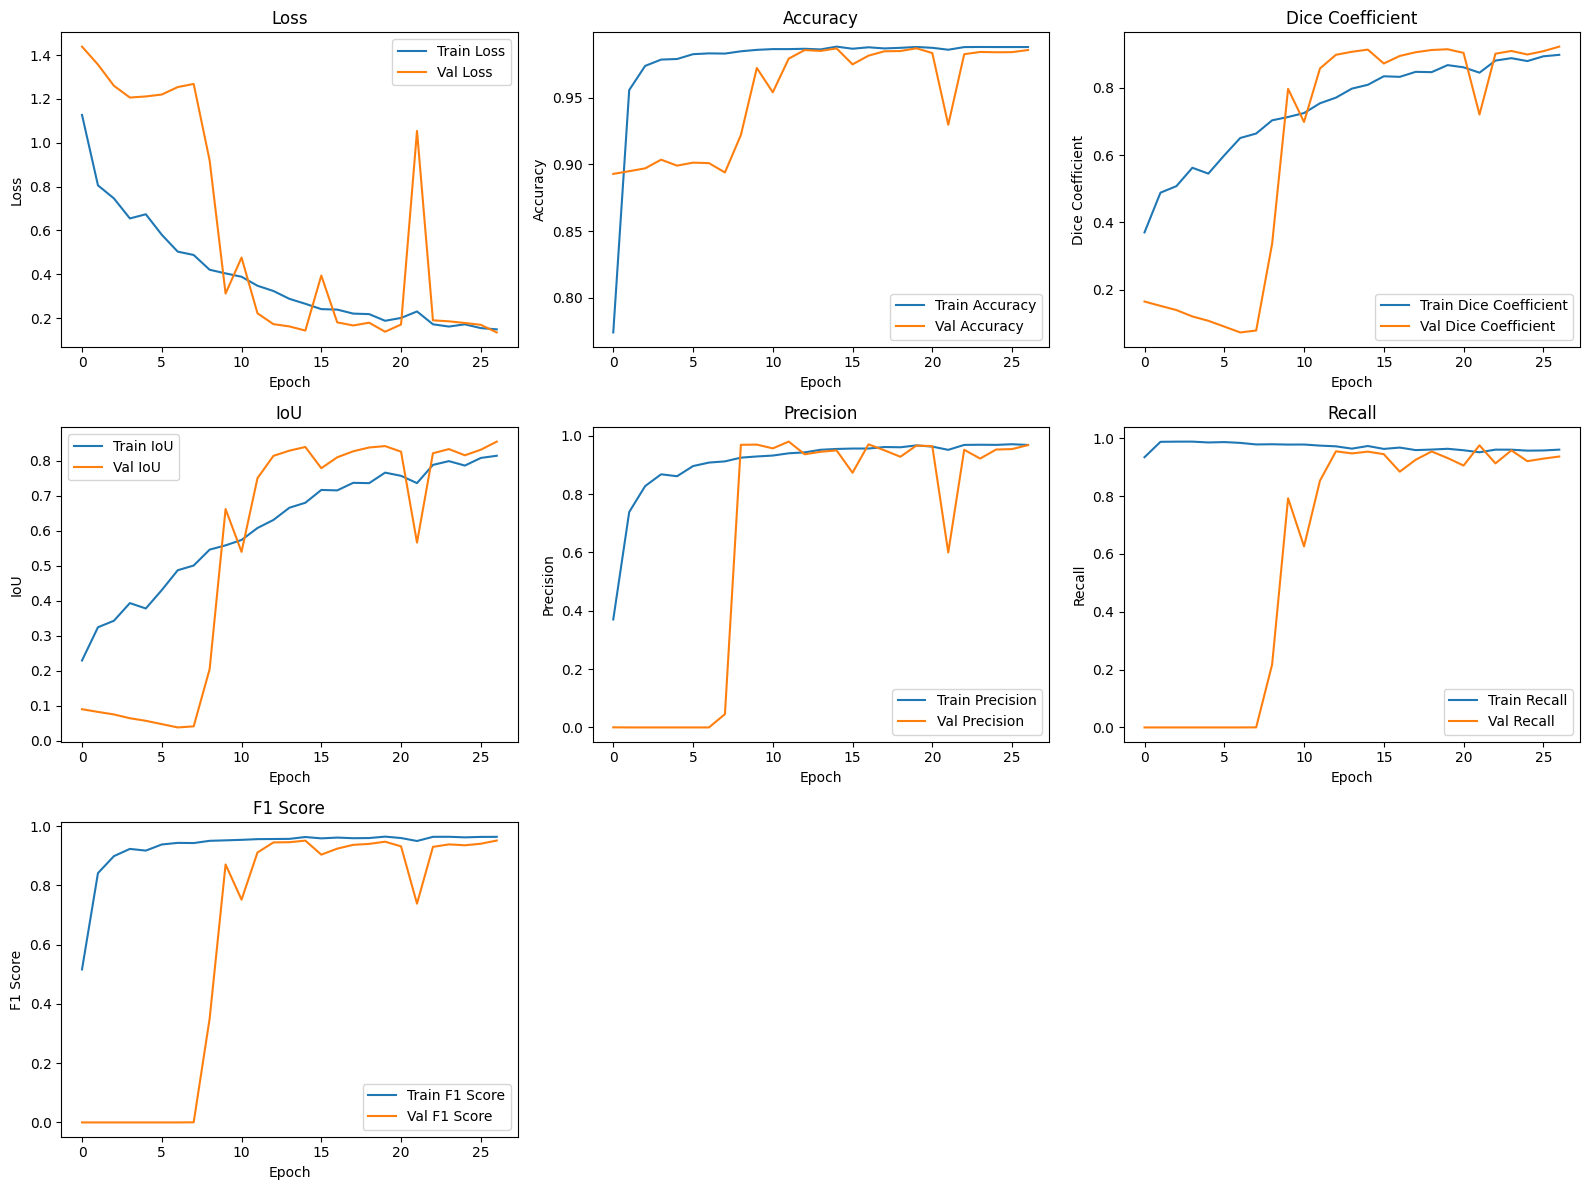

In [ ]:
# List of metrics to plot. Note that the keys in history.history depend on the metric function names.
metrics_to_plot = {
    'loss': 'Loss',  # Loss function (binary cross-entropy + dice loss)
    'accuracy': 'Accuracy',  # Binary accuracy
    'dice_coefficient': 'Dice Coefficient',  # Dice coefficient for segmentation performance
    'iou_metric': 'IoU',  # Intersection over Union (IoU)
    'precision_metric': 'Precision',  # Precision
    'recall_metric': 'Recall',  # Recall
    'f1_metric': 'F1 Score'  # F1 score
}

# Create subplots for train vs. validation metrics.
plt.figure(figsize=(16, 12))  # Set figure size for the plot
num_metrics = len(metrics_to_plot)  # Number of metrics to plot

# Loop through each metric and plot the corresponding graph.
for i, (key, title) in enumerate(metrics_to_plot.items(), 1):
    plt.subplot(3, 3, i)  # Create a 3x3 grid of subplots, fill each with a metric plot
    train_key = key  # Key for training metric
    val_key = 'val_' + key  # Key for validation metric (prefixed with 'val_')

    # Check if both the training and validation metrics exist in history
    if train_key in history_seg.history and val_key in history_seg.history:
        # Plot training and validation metrics
        plt.plot(history_seg.history[train_key], label=f'Train {title}')
        plt.plot(history_seg.history[val_key], label=f'Val {title}')
        plt.title(title)  # Set the title of the plot
        plt.xlabel('Epoch')  # Label for the x-axis
        plt.ylabel(title)  # Label for the y-axis
        plt.legend()  # Show legend for the plot
    else:
        print(f'Warning: {key} or {val_key} not found in history.')

# Adjust the layout of the subplots to avoid overlapping
plt.tight_layout()
plt.show()


In [ ]:
# ------------------------------
# Evaluate on the Training Dataset
# ------------------------------
print("\nEvaluating on training data:")

# Initialize the training data generator, using batch size and training data
train_generator = seg_generator(X_train_seg, y_train_seg, batch_size=BATCH_SIZE)

# Evaluate the model on the training data, using the generator to yield batches
train_eval = unet_model.evaluate(train_generator, steps=len(X_train_seg) // BATCH_SIZE, verbose=1)

# Print the training metrics names and their corresponding values
print("\nTrain Metrics:")
for name, value in zip(unet_model.metrics_names, train_eval):
    print(f"{name}: {value:.4f}")

# Extract specific training metrics from the evaluation result (first 7 metrics)
(train_loss,
 train_accuracy,
 train_dice,
 train_iou,
 train_precision,
 train_recall,
 train_f1) = train_eval[0:7]

# Print the selected training metrics in a human-readable format
print("\nSelected Training Metrics:")
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Dice Coefficient: {train_dice:.4f}")
print(f"Train IoU: {train_iou:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train Recall: {train_recall:.4f}")
print(f"Train F1 Score: {train_f1:.4f}")

# ------------------------------
# Evaluate on the Validation (Test) Dataset
# ------------------------------
print("\nEvaluating on validation data:")

# Initialize the validation data generator, using batch size and validation data
val_generator = seg_generator(X_val_seg, y_val_seg, batch_size=BATCH_SIZE)

# Evaluate the model on the validation data, using the generator to yield batches
test_eval = unet_model.evaluate(val_generator, steps=len(X_val_seg) // BATCH_SIZE, verbose=1)

# Print the validation (test) metrics names and their corresponding values
print("\nTest Metrics:")
for name, value in zip(unet_model.metrics_names, test_eval):
    print(f"{name}: {value:.4f}")

# Extract specific test metrics from the evaluation result (first 7 metrics)
(test_loss,
 test_accuracy,
 test_dice,
 test_iou,
 test_precision,
 test_recall,
 test_f1) = test_eval[0:7]

# Print the selected test metrics in a human-readable format
print("\nSelected Test Metrics:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Dice Coefficient: {test_dice:.4f}")
print(f"Test IoU: {test_iou:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")



Evaluating on training data:
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9885 - dice_coefficient: 0.9334 - f1_metric: 0.9647 - iou_metric: 0.8754 - loss: 0.1004 - precision_metric: 0.9759 - recall_metric: 0.9540

Train Metrics:
loss: 0.0990
compile_metrics: 0.9885

Selected Training Metrics:
Train Loss: 0.0990
Train Accuracy: 0.9885
Train Dice Coefficient: 0.9350
Train IoU: 0.8781
Train Precision: 0.9776
Train Recall: 0.9540
Train F1 Score: 0.9655

Evaluating on validation data:
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9850 - dice_coefficient: 0.9167 - f1_metric: 0.9464 - iou_metric: 0.8478 - loss: 0.1380 - precision_metric: 0.9709 - recall_metric: 0.9253

Test Metrics:
loss: 0.1438
compile_metrics: 0.9844

Selected Test Metrics:
Test Loss: 0.1438
Test Accuracy: 0.9844
Test Dice Coefficient: 0.9134
Test IoU: 0.8417
Test Precision: 0.9709
Test Recall: 0.9196
Test F1 Score: 0.9437


In [ ]:
from tensorflow.keras.models import load_model

# Define all custom objects again (used after loading)
custom_objects = {
    'dice_coefficient': dice_coefficient,  # Custom Dice Coefficient metric
    'iou_metric': iou_metric,              # Custom IoU metric
    'precision_metric': precision_metric,  # Custom Precision metric
    'recall_metric': recall_metric,        # Custom Recall metric
    'f1_metric': f1_metric,                # Custom F1 Score metric
    'combined_loss': combined_loss         # Custom loss function
}

# Load the saved model without compiling
model_path = '/content/drive/MyDrive/models/unet_segmentation_model.h5'
unet_model = load_model(model_path, custom_objects=custom_objects, compile=False)

# Recompile the model with correct optimizer, loss, and metrics
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                   loss=combined_loss,
                   metrics=[
                       tf.keras.metrics.BinaryAccuracy(name='accuracy'),  # Standard binary accuracy metric
                       dice_coefficient,                                  # Custom Dice Coefficient metric
                       iou_metric,                                        # Custom IoU metric
                       precision_metric,                                  # Custom Precision metric
                       recall_metric,                                     # Custom Recall metric
                       f1_metric                                          # Custom F1 Score metric
                   ])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

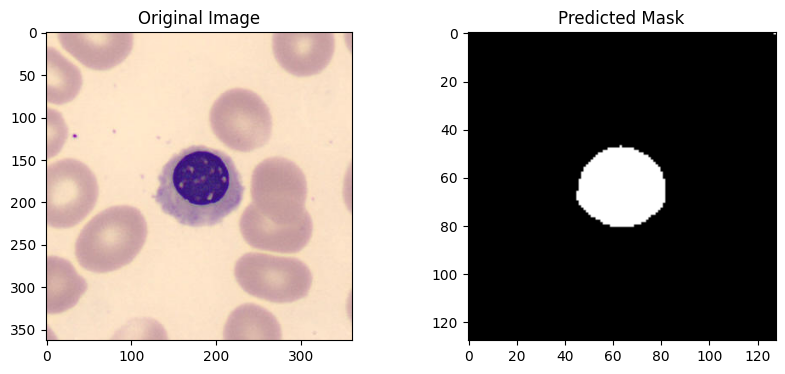

In [ ]:
from google.colab import files

# Function to preprocess image before feeding it into the model
def preprocess_image_for_segmentation(path):
    # Read the image from the given path
    img = cv2.imread(path)

    # Convert the image from BGR (OpenCV default) to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image to (128, 128) for model input
    img = cv2.resize(img, (128, 128))

    # Normalize the image to the range [0, 1] and add batch dimension
    return np.expand_dims(img / 255.0, axis=0)

# Load and predict the mask for a given image
test_img_path = '/content/ERB_896545.jpg'

# Preprocess the image
img_input = preprocess_image_for_segmentation(test_img_path)

# Predict the segmentation mask for the image
pred_mask = unet_model.predict(img_input)[0]  # Remove batch dimension

# Apply a threshold of 0.5 to the predicted mask to get a binary mask
pred_mask = (pred_mask > 0.5).astype(np.uint8)

# Save the predicted mask as an image
save_path = '/content/predicted_mask.png'
cv2.imwrite(save_path, pred_mask.squeeze() * 255)  # Multiply by 255 to get a proper mask image

# Optional: Download the mask image in Google Colab
files.download(save_path)

# Display the original image and the predicted mask side by side
plt.figure(figsize=(10, 4))

# Show the original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(test_img_path)[..., ::-1])  # Convert BGR to RGB for proper display
plt.title("Original Image")

# Show the predicted mask
plt.subplot(1, 2, 2)
plt.imshow(pred_mask.squeeze(), cmap='gray')  # Display the mask in grayscale
plt.title("Predicted Mask")

# Display the plots
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


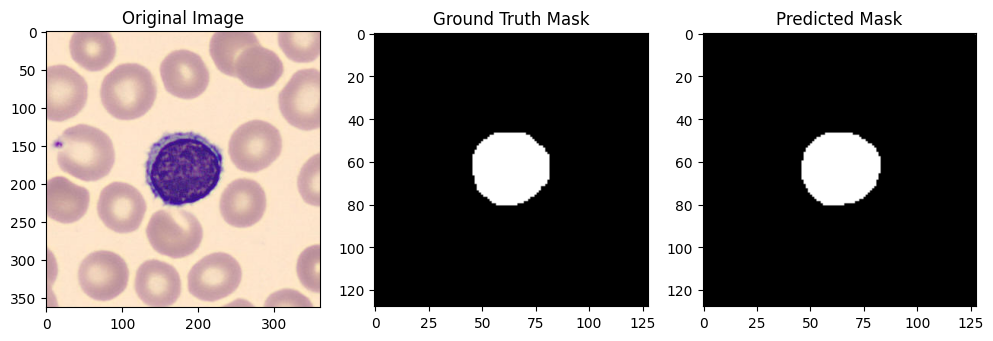

IoU: 0.9552
Dice Coefficient: 0.9771
Accuracy: 0.9972


In [ ]:

# 1. Load and preprocess image
def preprocess_image_for_segmentation(path):
    # Read the image from the specified path
    img = cv2.imread(path)

    # Convert the image from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image to (128, 128) for model input
    img = cv2.resize(img, (128, 128))

    # Normalize the image to the range [0, 1] and add batch dimension
    return np.expand_dims(img / 255.0, axis=0)

# 2. Load and preprocess ground truth mask
def preprocess_mask(path):
    # Read the mask from the specified path as a grayscale image
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Resize the mask to (128, 128)
    mask = cv2.resize(mask, (128, 128))

    # Binarize the mask: convert values greater than 127 to 1 (foreground) and others to 0 (background)
    mask = (mask > 127).astype(np.uint8)

    return mask

# Provide image and corresponding mask path
# In this case, change to the image and mask paths as needed
test_img_path = '/content/LY_16740.jpg'
gt_mask_path = '/content/LY_16740.png'

# 3. Predict
# Preprocess and feed the image into the U-Net model to get the predicted mask
img_input = preprocess_image_for_segmentation(test_img_path)
pred_mask = unet_model.predict(img_input)[0]

# Threshold the predicted mask to get a binary result (0 or 1)
pred_mask = (pred_mask > 0.5).astype(np.uint8)

# 4. Ground truth mask
# Preprocess the ground truth mask
true_mask = preprocess_mask(gt_mask_path)

# 5. Resize predicted mask to match the size of the ground truth mask
pred_mask_resized = cv2.resize(pred_mask.squeeze(), (128, 128))

# 6. Compute metrics
# Intersection: pixel-wise logical AND of true and predicted masks
intersection = np.logical_and(true_mask, pred_mask_resized).sum()

# Union: pixel-wise logical OR of true and predicted masks
union = np.logical_or(true_mask, pred_mask_resized).sum()

# IoU (Intersection over Union): ratio of intersection over union
iou = intersection / (union + 1e-6)  # Adding a small epsilon to avoid division by zero

# Dice coefficient: a measure of overlap between the true and predicted masks
dice = (2 * intersection) / (np.sum(true_mask) + np.sum(pred_mask_resized) + 1e-6)

# Accuracy: pixel-wise comparison between true and predicted masks
accuracy = accuracy_score(true_mask.flatten(), pred_mask_resized.flatten())

# 7. Display results
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(cv2.imread(test_img_path)[..., ::-1])  # Convert from BGR to RGB for display
plt.title("Original Image")

# Ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask, cmap='gray')  # Display the ground truth mask in grayscale
plt.title("Ground Truth Mask")

# Predicted mask
plt.subplot(1, 3, 3)
plt.imshow(pred_mask_resized, cmap='gray')  # Display the predicted mask in grayscale
plt.title("Predicted Mask")

# Show the plot with all images
plt.show()

# 8. Print metrics
print(f"IoU: {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")
print(f"Accuracy: {accuracy:.4f}")


Category 'platelet': 2338 images segmented.


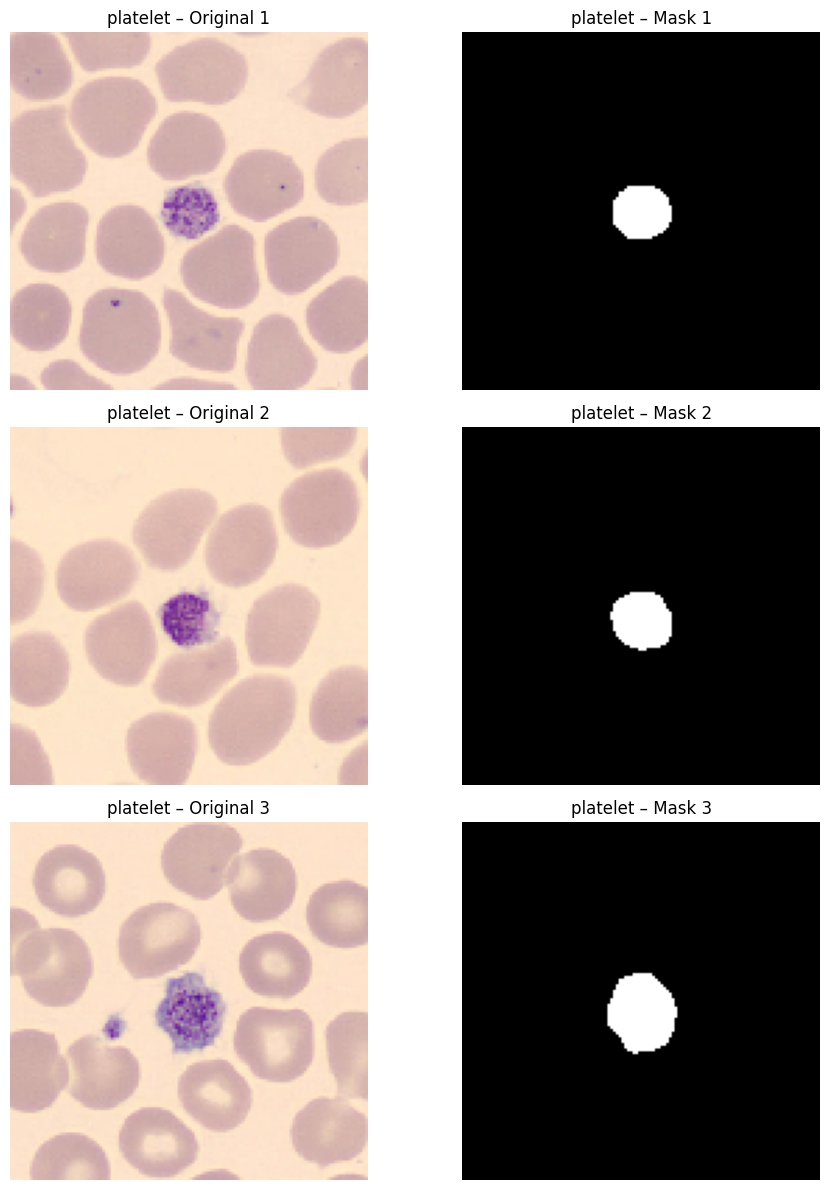

Category 'eosinophil': 2507 images segmented.


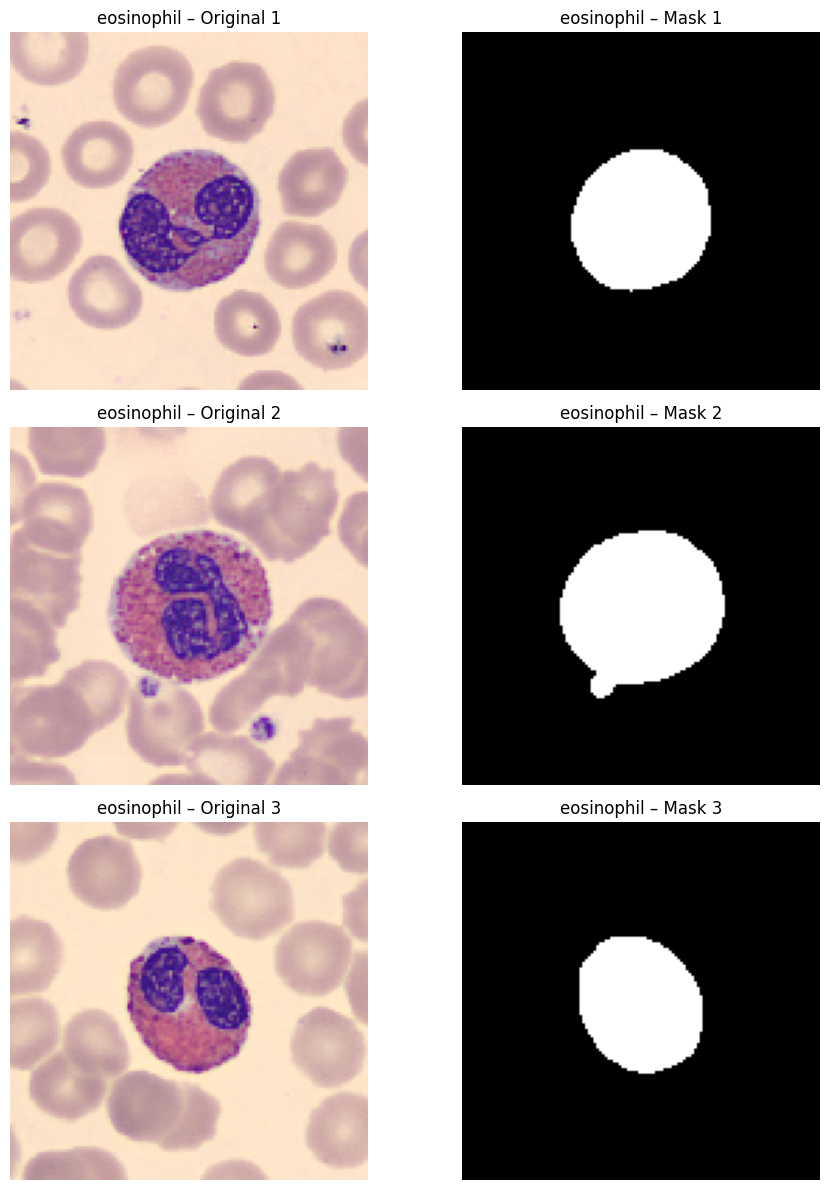

Category 'monocyte': 1410 images segmented.


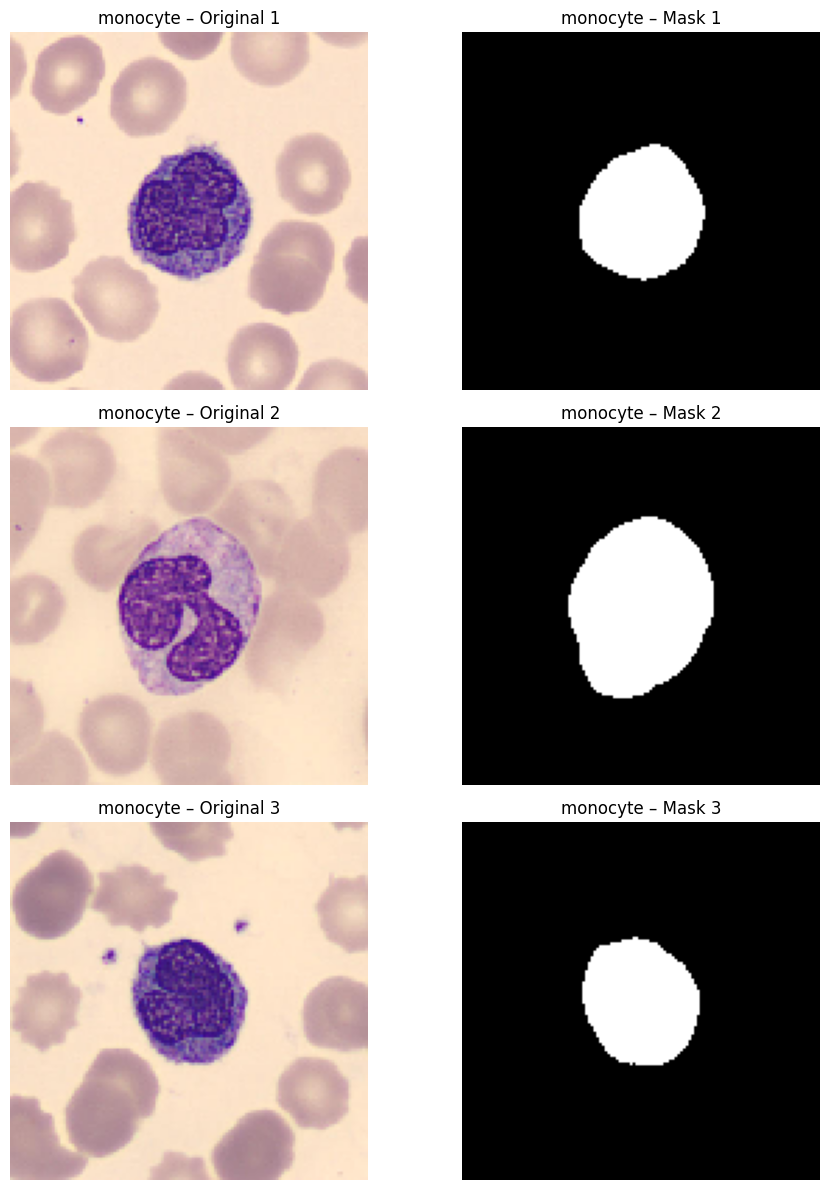

Category 'neutrophil': 3319 images segmented.


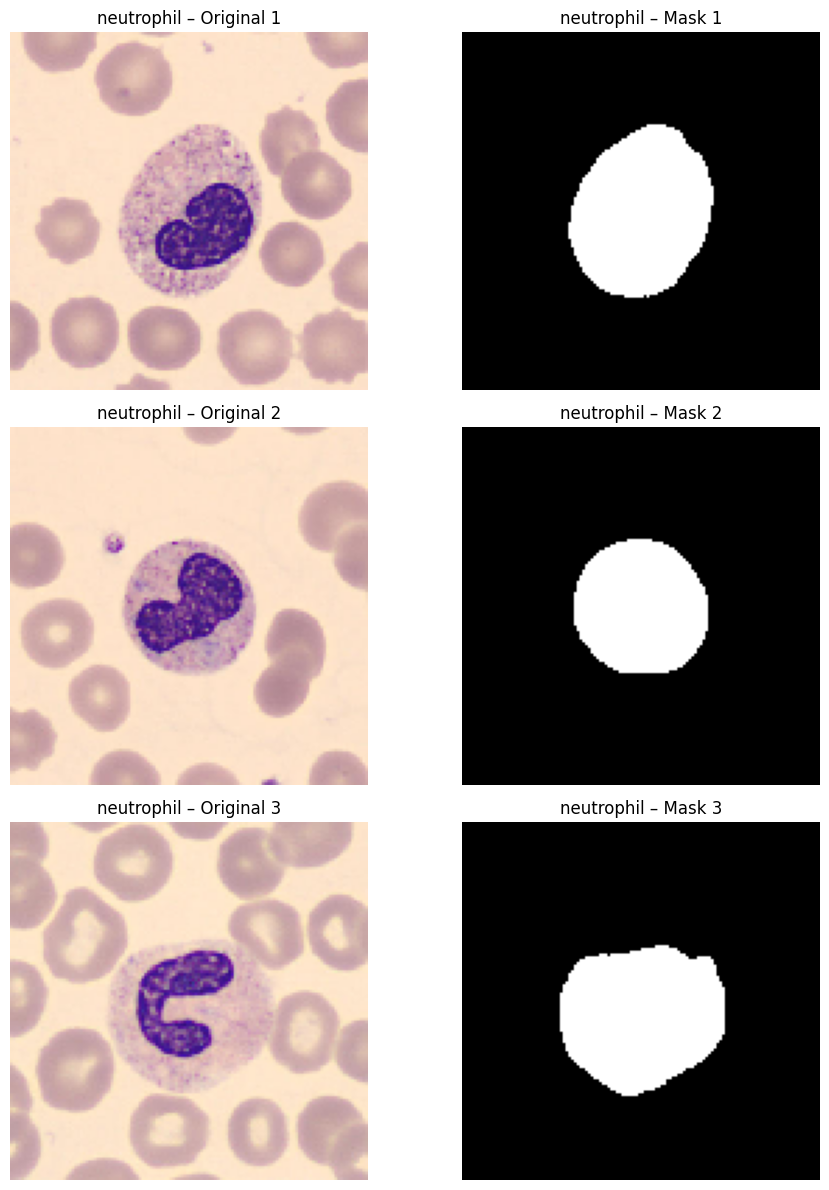

Category 'ig': 2885 images segmented.


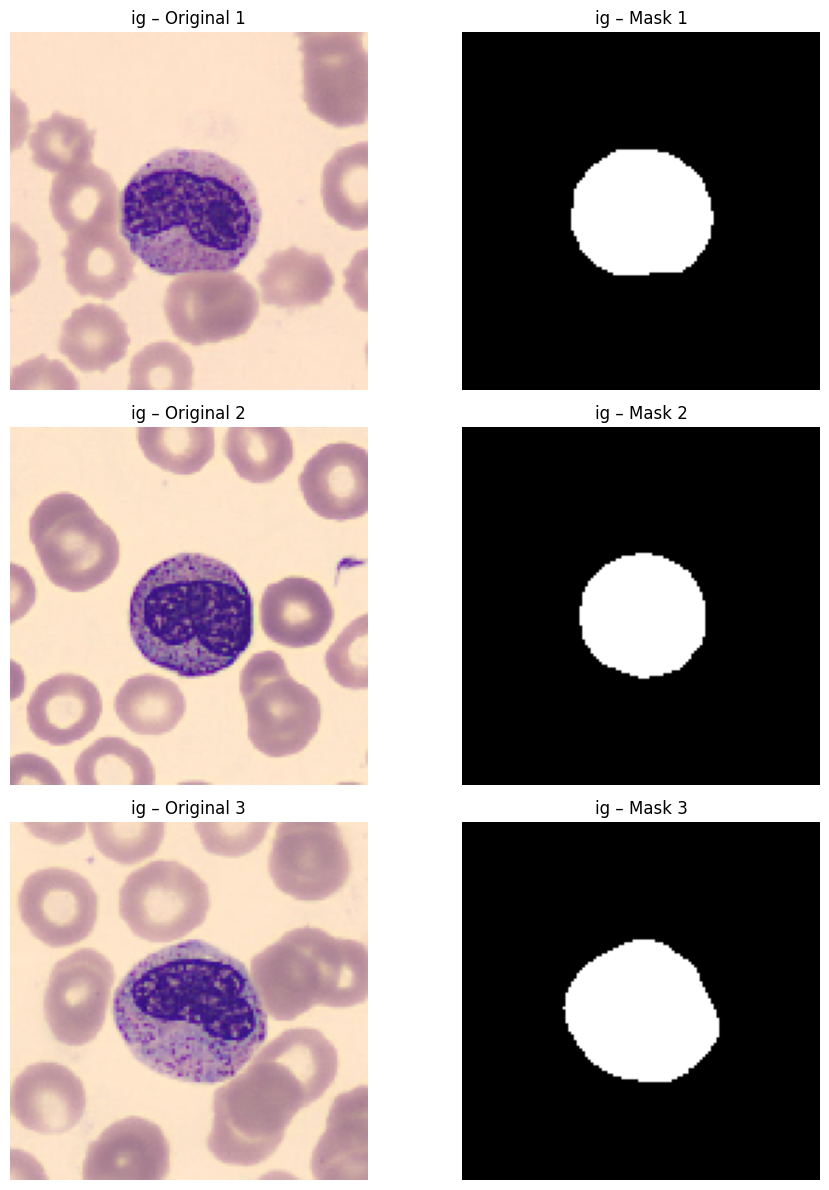

Category 'erythroblast': 1541 images segmented.


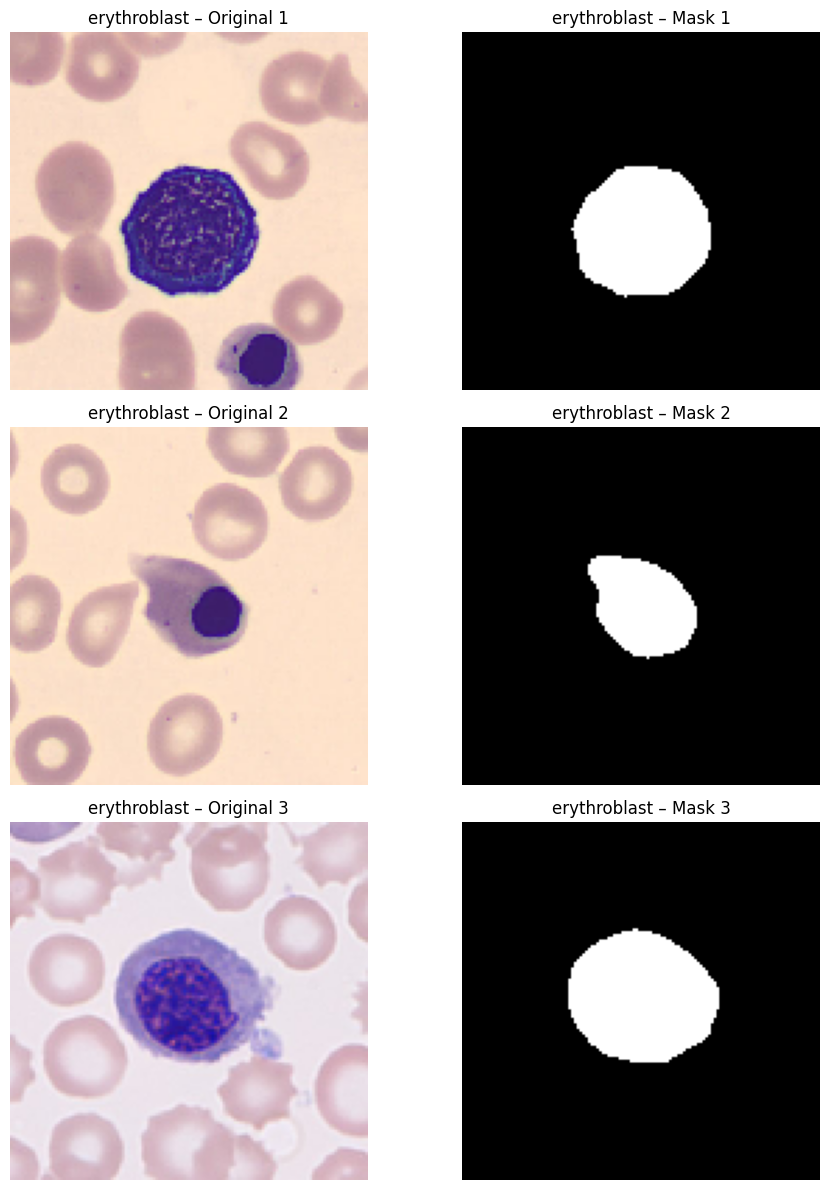

Category 'lymphocyte': 1204 images segmented.


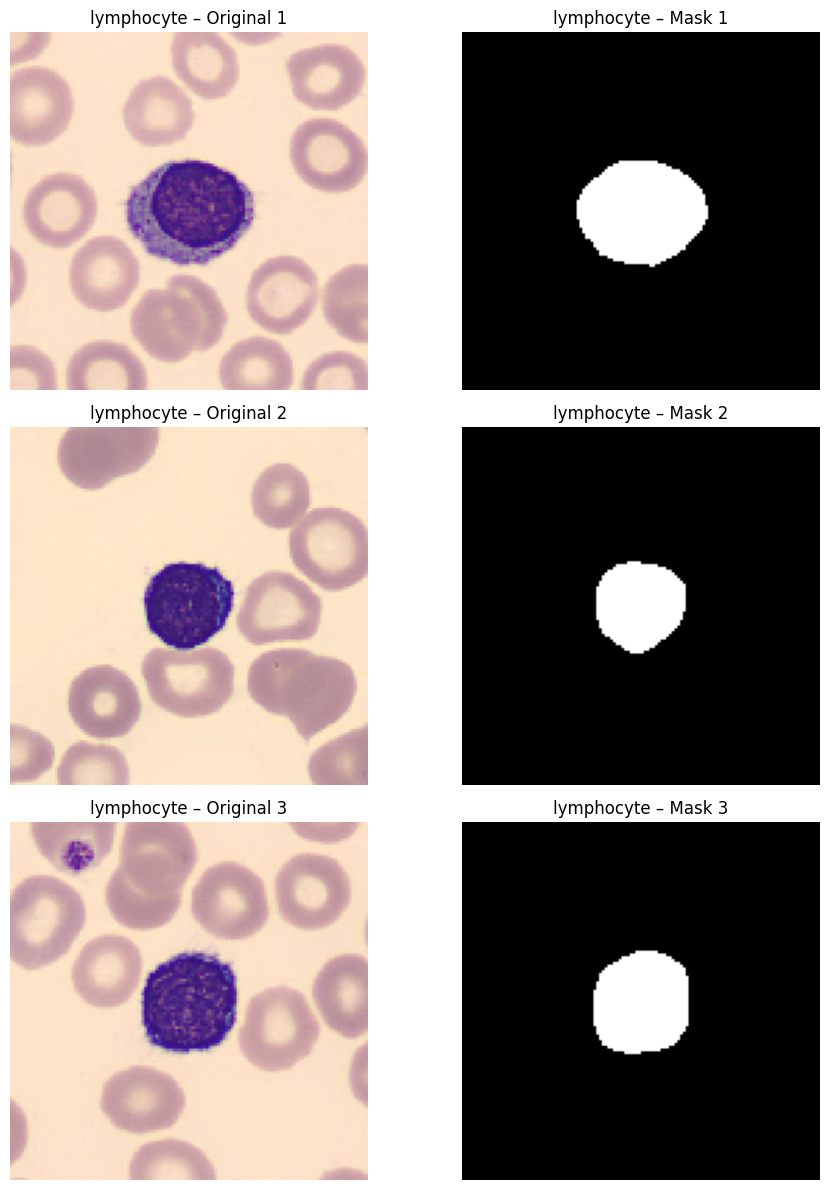

Category 'basophil': 1208 images segmented.


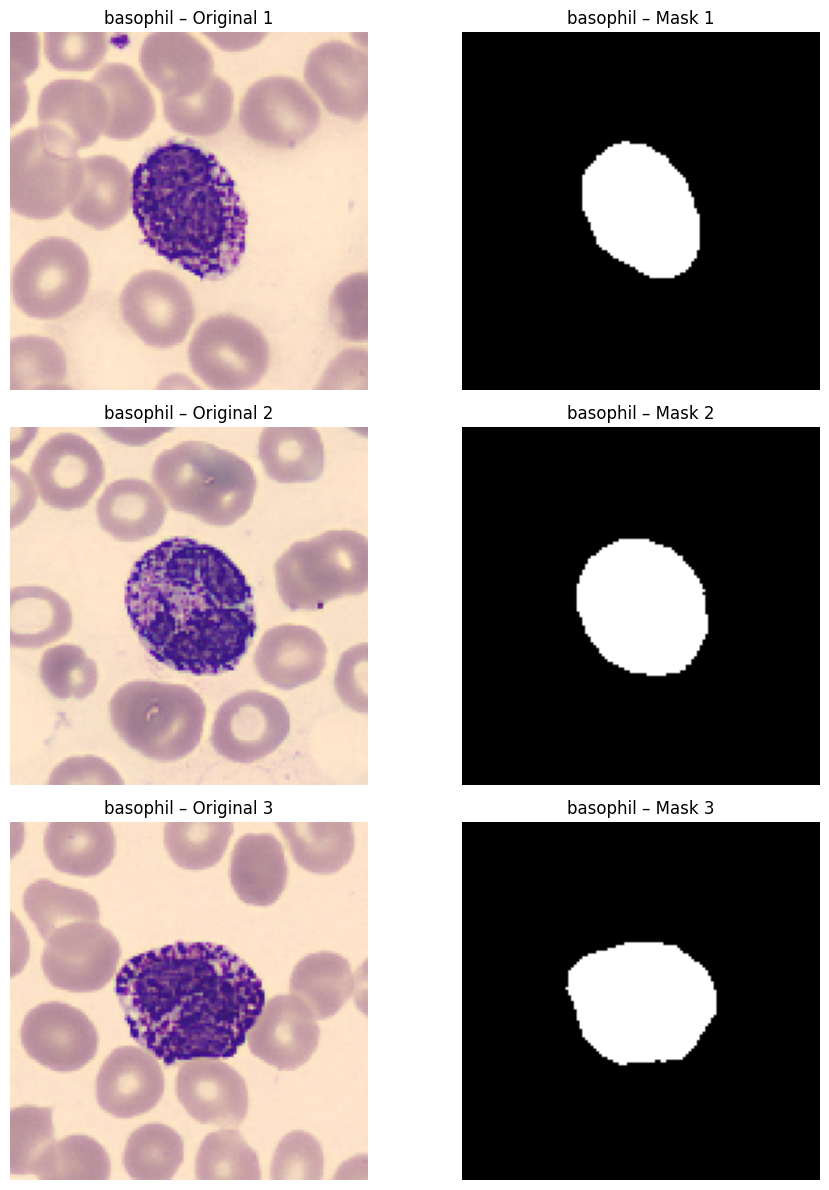


Segmentation Summary:
  - platelet: 2338 images processed
  - eosinophil: 2507 images processed
  - monocyte: 1410 images processed
  - neutrophil: 3319 images processed
  - ig: 2885 images processed
  - erythroblast: 1541 images processed
  - lymphocyte: 1204 images processed
  - basophil: 1208 images processed
✅ All images have been processed; masks saved with same names as original images.


In [ ]:
import os  # Importing os module for handling file paths and directory operations
import numpy as np  # Importing numpy for array operations
import tensorflow as tf  # Importing TensorFlow for model loading and deep learning functions
import matplotlib.pyplot as plt  # Importing matplotlib for plotting images and masks
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img  # Importing image preprocessing functions from Keras
from tensorflow.keras.models import load_model  # Importing the function to load pre-trained models
from skimage import measure  # Importing skimage measure for image component labeling

# --- Custom Metrics and Losses ---
def dice_coefficient(y_true, y_pred, smooth=1e-6):  # Define the Dice coefficient as a custom metric
    y_true_f = tf.keras.backend.flatten(y_true)  # Flatten true labels
    y_pred_f = tf.keras.backend.flatten(y_pred)  # Flatten predicted labels
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)  # Calculate intersection
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)  # Compute Dice coefficient

def iou_coefficient(y_true, y_pred, smooth=1e-6):  # Define Intersection over Union (IoU) as a custom metric
    y_true_f = tf.keras.backend.flatten(y_true)  # Flatten true labels
    y_pred_f = tf.keras.backend.flatten(y_pred)  # Flatten predicted labels
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)  # Calculate intersection
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection  # Calculate union
    return (intersection + smooth) / (union + smooth)  # Compute IoU coefficient

def combined_loss(y_true, y_pred):  # Define combined loss function using Dice and binary crossentropy
    return 1 - dice_coefficient(y_true, y_pred) + tf.keras.losses.binary_crossentropy(y_true, y_pred)  # Return combined loss

# Define custom loss and metric functions in a dictionary for use with the model
custom_objects = {
    'combined_loss': combined_loss,  # Adding combined loss function
    'iou_coefficient': iou_coefficient,  # Adding IoU metric
    'dice_coefficient': dice_coefficient  # Adding Dice coefficient metric
}

# --- Load Pre-trained Model (without compiling) ---
model_path = '/content/drive/MyDrive/models/unet_segmentation_model.h5'  # Path to the pre-trained U-Net model
model = load_model(model_path, custom_objects=custom_objects, compile=False)  # Load the model with custom loss and metrics, without compilation

# --- Optional: Keep Largest Connected Component ---
def keep_largest_component_with_fallback(mask):  # Function to retain the largest connected component in a binary mask
    labels = measure.label(mask)  # Label connected components in the binary mask
    if labels.max() == 0:  # If no components are found
        return mask  # Return the original mask
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:]) + 1  # Find the largest connected component
    return largestCC.astype(np.uint8)  # Return the largest connected component as uint8 mask

# --- Image Preprocessing ---
def load_image(image_path, target_size=(128, 128)):  # Function to load and preprocess images
    img = load_img(image_path, target_size=target_size)  # Load the image and resize it
    return img_to_array(img) / 255.0  # Convert image to array and normalize pixel values to [0, 1]

# --- Predict Mask ---
def predict_mask(image_array, threshold=0.5):  # Function to predict segmentation mask for an image
    inp = np.expand_dims(image_array, axis=0)  # Add batch dimension to the image
    pred = model.predict(inp, verbose=0)[0, ..., 0]  # Predict mask using the model (get the first channel)
    bin_mask = (pred > threshold).astype(np.uint8)  # Apply threshold to binarize the mask
    clean_mask = keep_largest_component_with_fallback(bin_mask)  # Keep the largest connected component
    return clean_mask  # Return the cleaned mask

# --- Process and Save Single Image with Same Name ---
def process_file(input_path, output_path, target_size=(128, 128)):  # Function to process a single image
    img_arr = load_image(input_path, target_size)  # Load and preprocess the image
    mask = predict_mask(img_arr)  # Predict the segmentation mask
    mask_img = array_to_img(np.expand_dims(mask, axis=-1) * 255.0)  # Convert mask to image format (multiply by 255 to scale)

    # Keep same filename as input image but force .png extension
    img_name = os.path.splitext(os.path.basename(input_path))[0] + ".png"  # Get the original image filename with a .png extension
    save_path = os.path.join(output_path, img_name)  # Define the path to save the mask
    mask_img.save(save_path)  # Save the mask image
    return save_path  # Return the path to the saved mask

# --- Display Image/Mask Pairs ---
def display_image_mask_pairs(pairs, category):  # Function to display image and corresponding mask pairs
    plt.figure(figsize=(10, 4 * len(pairs)))  # Set up the figure for plotting
    for i, (orig, msk) in enumerate(pairs):  # Loop through each image-mask pair
        o = load_img(orig, target_size=(128, 128))  # Load the original image
        m = load_img(msk, color_mode='grayscale', target_size=(128, 128))  # Load the mask image in grayscale
        plt.subplot(len(pairs), 2, 2*i+1)  # Plot the original image in the first column
        plt.imshow(o); plt.title(f"{category} – Original {i+1}"); plt.axis('off')  # Display the original image
        plt.subplot(len(pairs), 2, 2*i+2)  # Plot the mask image in the second column
        plt.imshow(m, cmap='gray'); plt.title(f"{category} – Mask {i+1}"); plt.axis('off')  # Display the mask image
    plt.tight_layout(); plt.show()  # Adjust layout and display the plots

# --- Process a Folder of Images ---
def process_category(in_dir, out_dir, target_size=(128, 128)):  # Function to process all images in a folder
    os.makedirs(out_dir, exist_ok=True)  # Create output directory if it doesn't exist
    count = 0  # Initialize image count
    samples = []  # List to store sample image-mask pairs for display
    for fname in os.listdir(in_dir):  # Loop through all files in the input directory
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):  # Skip non-image files
            continue
        src = os.path.join(in_dir, fname)  # Get the full path of the image
        try:
            saved_mask_path = process_file(src, out_dir, target_size)  # Process the image and save the mask
            count += 1  # Increment the count of processed images
            if len(samples) < 3:  # Keep only the first 3 image-mask pairs for display
                samples.append((src, saved_mask_path))
        except Exception as e:  # Handle any errors during processing
            print(f"Error processing {src}: {e}")
    print(f"Category '{os.path.basename(in_dir)}': {count} images segmented.")  # Print the number of images processed
    if samples:  # If there are samples, display them
        display_image_mask_pairs(samples, os.path.basename(in_dir))  # Display image-mask pairs
    return count  # Return the number of images processed

# --- Process All Images Recursively ---
def process_all_images(root_in, root_out, target_size=(128, 128)):  # Function to process all images recursively in a directory
    os.makedirs(root_out, exist_ok=True)  # Create output root directory if it doesn't exist
    items = os.listdir(root_in)  # List items in the input directory
    dirs = [d for d in items if os.path.isdir(os.path.join(root_in, d))]  # Get subdirectories
    files = [f for f in items if f.lower().endswith(('.jpg', '.jpeg', '.png'))]  # Get image files
    summary = {}  # Dictionary to store the summary of processed images by category
    if dirs:  # If subdirectories are found, process each category
        for d in dirs:
            cnt = process_category(os.path.join(root_in, d), os.path.join(root_out, d), target_size)  # Process each category
            summary[d] = cnt  # Store the count of processed images by category
    elif files:  # If there are no subdirectories, process the files directly
        summary['default'] = process_category(root_in, root_out, target_size)  # Process files in the root directory
    else:
        print("No images found.")  # If no images are found, print a message
    print("\nSegmentation Summary:")  # Print summary of processed images
    for cls, num in summary.items():  # Loop through the summary and print the results
        print(f"  - {cls}: {num} images processed")

# --- Run ---
input_folder = "/content/drive/MyDrive/final_DHinput/data"  # Define the input folder path containing images
output_folder = "/content/drive/MyDrive/OUTPUT_MASK"  # Define the output folder path for saving masks
process_all_images(input_folder, output_folder)  # Call the function to process all images
print("✅ All images have been processed; masks saved with same names as original images.")  # Print completion message
